#Figure 8 - Functional imaging

This notebook loads in the data corresponding to figure 8, both the low and high magnification data sets.

We then compute:
- The mean intenstity image of the low magnification 8A)
- The crosscorrelation image with region 1, 8B)
- The mean intenstity image of the high magnification 8C) with rois
- The example traces and roi correlation histograms

## Setup plotting

In [27]:
from showit import image
%matplotlib inline

In [29]:
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

##Load in low magnigication data

In [5]:
from thunder.images import frombinary

path = 's3://neuro-datasets/svoboda-lab/2pRAM-paper/00'

# we only load in the first 100 out of 2628 frames as the data is large
data = frombinary(path + '/images', stop = 100)

In [6]:
data

Images
mode: local
dtype: int16
shape: (100, 500, 468)

## Compute and inspect the mean image

In [7]:
mean = data.mean().toarray()

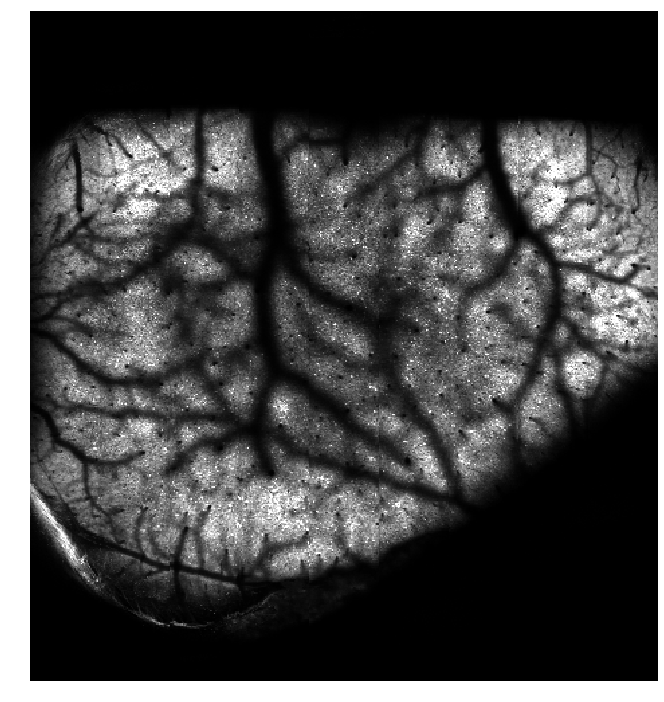

In [8]:
image(mean, clim=(0, 2500), size = 12);

In [5]:
#from skimage.io import imsave

#imsave(path + '/summary/mean.tif', mean.astype('float32'), plugin='tifffile', photometric='minisblack')

##Average activity in subregions

In [13]:
from json import loads
from regional import many
from requests import get

path = 'https://s3.amazonaws.com/neuro-datasets/svoboda-lab/2pRAM-paper/00'

r = get(path + '/sources/sources.json').content
sources = loads(r)

regions = many([x['coordinates'] for x in sources])

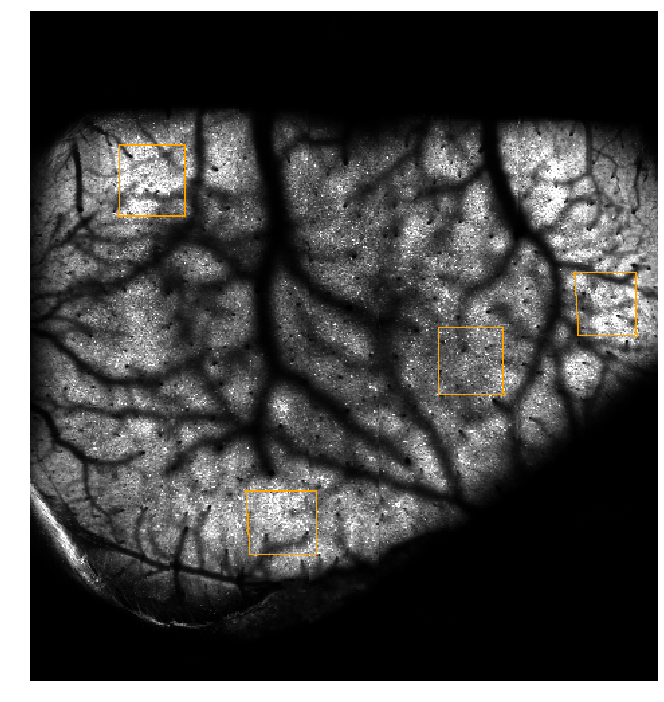

In [14]:
img = regions.mask(base=(mean/2500).clip(0,1), stroke='orange', fill = None)
image(img, size = 12);

In [ ]:
from extraction.model import ExtractionModel

em = ExtractionModel(regions)
traces = em.transform(data)
traces.tobinary(path + '/traces', overwrite = True)

In [11]:
from numpy import array
time = array([float(x)/4.38 for x in range(traces.shape[1])])

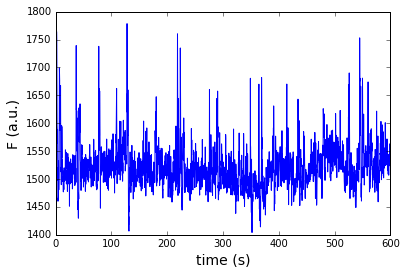

In [12]:
from matplotlib.pyplot import plot, xlim, xlabel, ylabel 

plot(time, traces[0].values.T);
xlabel('time (s)', fontsize=14);
xlim([0, 600])
ylabel('F (a.u.)', fontsize=14);

##Make correlation map

In [15]:
records = data.uniform_filter(5).toseries(size = 10)

In [16]:
corr = records.correlate(traces[0].values).toarray()

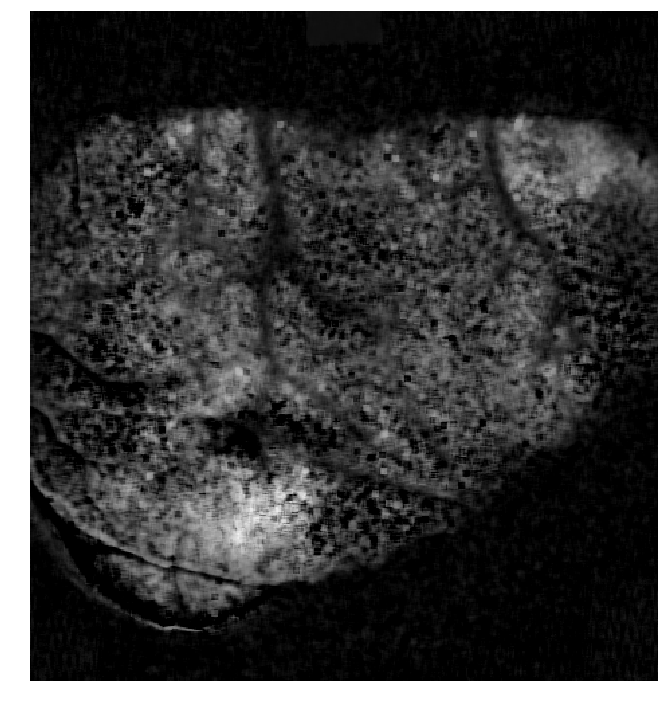

In [17]:
image(corr, clim = (0, 0.7), size = 12);

#Load in high magnigication data

In [20]:
from thunder.images import frombinary

path = 's3://neuro-datasets/svoboda-lab/2pRAM-paper/01'

# we only load in the first 100 out of 6000 frames as the data is large
data = frombinary(path + '/images' , stop = 100)

In [21]:
data

Images
mode: local
dtype: int16
shape: (100, 4, 512, 512)

##Perform motion correction

In [22]:
from registration import CrossCorr

# use first 60 frames as a reference
reference = data[:60].mean().toarray()

# perform registration on each plane independently
algorithm = CrossCorr(axis=0)
model = algorithm.fit(data, reference)
registered = model.transform(data)

In [23]:
mean = registered.mean().toarray()

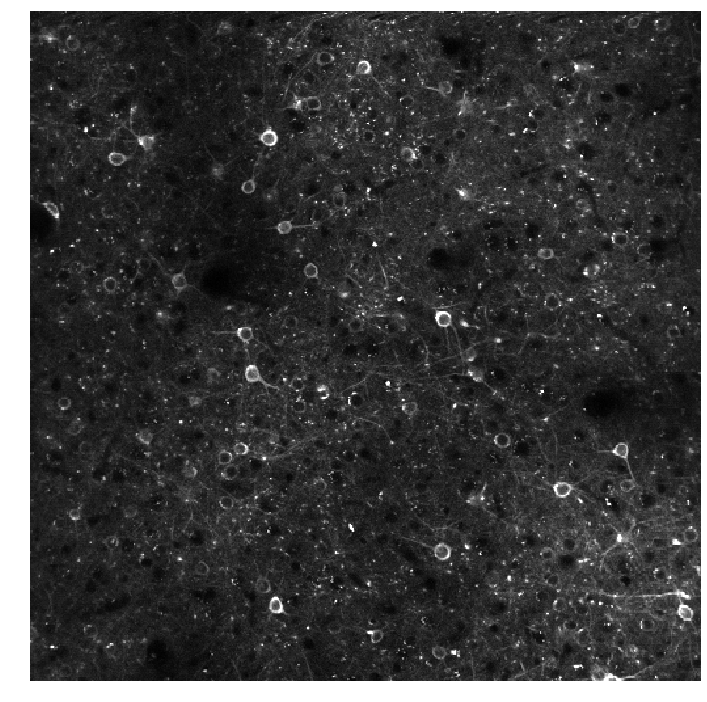

In [24]:
image(mean[3], clim=(0, 2500), size = 12);

##Display sources

In [25]:
from json import loads
from regional import many
from requests import get

path = 'https://s3.amazonaws.com/neuro-datasets/svoboda-lab/2pRAM-paper/01'


regions = []
for i in range(4):
    r = get(path + '/sources/sources-%d.json' % i).content
    sources = loads(r)
    regions.append(many([x['coordinates'] for x in sources]))

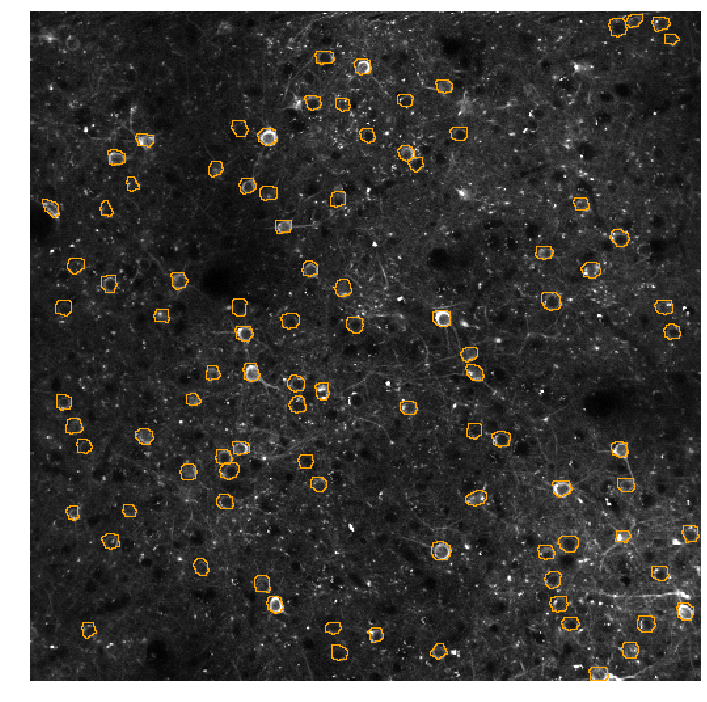

In [26]:
plane = 3
img = regions[plane].mask(base=(mean[plane]/2500).clip(0,1), stroke='orange', fill = None)
image(img, size = 12);

##Compute and inspect neuron activity traces

In [25]:
from extraction.model import ExtractionModel

traces = []
for plane in range(4):
    em = ExtractionModel(regions[plane])
    trace = em.transform(registered[:,plane,:,:].squeeze()).normalize('window', window=500)
    trace.tobinary(path + '/traces/%d' % plane, overwrite = True)
    traces.append(trace)

In [26]:
from numpy import array
time = array([float(x)/9.66 for x in range(traces[0].shape[1])])

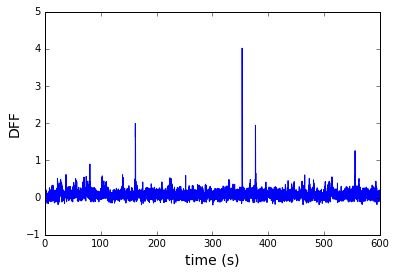

In [27]:
from matplotlib.pyplot import plot, xlim, xlabel, ylabel 

plane = 0
neuron = 20

plot(time, traces[plane][neuron].values.T);
xlabel('time (s)', fontsize=14);
xlim([0, 600])
ylabel('DFF', fontsize=14);

##Extract temporal correlations

In [28]:
# compute maximum activity in region 1
avg = traces[0].max()

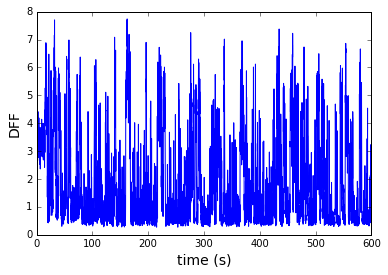

In [30]:
from matplotlib.pyplot import plot, xlim, xlabel, ylabel 

plot(time, avg.values.T);
xlabel('time (s)', fontsize = 14);
xlim([0, 600])
ylabel('DFF', fontsize = 14);

In [31]:
# compute correlation with timeseries of each individual neuron
corr = [t.correlate(avg).values for t in traces]

##Create histograms of correlation coefficients

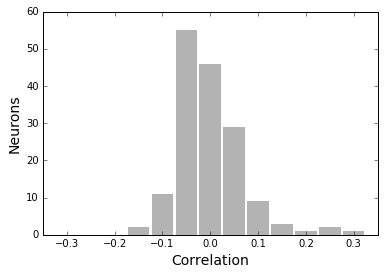

In [32]:
from numpy import linspace
from matplotlib.pyplot import hist, xlim, xlabel, ylabel 

plane = 2
hist(corr[plane],bins=linspace(-.525,.525,22), rwidth=0.9, edgecolor='none', color = [0.7,0.7,0.7]);
xlim([-.35, .35])
xlabel('Correlation', fontsize = 14);
ylabel('Neurons', fontsize = 14);